# Laboratorio 4 - Redes Neuronales

Grupo 10:
- Agustín Recoba  
- Steven Estramil 
- Daniel Padrón   

# Introduccion al problema

Esta tarea es introductoria al tema de Redes Neuronales. 
El objetivo es implementar un modelo de aprendizaje automático que clasifique imágenes de prendas de vestir.

El dataset será Fashion-MNIST, un conjunto de datos con imágenes de 10 tipos diferentes de artículos de la empresa de vestimenta Zalando, con 60.000 instancias de entrenamiento y 10.000 de evaluación. Cada imagen está en escala de grises y tiene un tamaño de 28x28 píxeles. A ella está asociada una etiqueta entera en el rango 0-9, representando cada categoría. 

Comenzamos con la importación de las diferentes librerías que utilizaremos.

In [1]:
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn as nn
import torch.utils.data as torchdata

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Semilla para reproducibilidad
Se elige la semilla 2023 para garantizar que los resultados sean reproducibles. 

In [2]:
import random, os
seed = 2023

# python
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

# numpy
np.random.seed(seed)

# pytorch
torch.manual_seed(seed)
torch.use_deterministic_algorithms(True)

Preparamos el dispositivo a utilizar, priorizando una GPU frente a la CPU. Para asegurar reproducibilidad se debe usar CPU. En caso de configurar CUDA igualmente, se debe configurar en la celda anterior torch.use_deterministic_algorithms(False).

En caso de querer ver los mismos datos que nosotros, se guardaron los datos obtenidos en los archivos .csv en la raiz y en la carpeta backup. 
En tal caso, no ejecutar las celdas con un warning para no sobreescribir los archivos y poder visualizar los mismos datos.

Para más información:
https://pytorch.org/docs/stable/notes/randomness.html
https://docs.nvidia.com/cuda/cublas/index.html#cublasApi_reproducibility

In [3]:
device = torch.device("cpu" if not torch.cuda.is_available() else "cuda")
device

device(type='cpu')

Procedemos a la carga de los datos de entrenamiento y prueba.

In [4]:
mnist_train = datasets.FashionMNIST(
    root="./data_train",
    train=True,
    download=True,
    transform=transforms.ToTensor(),
)

In [5]:
mnist_test = datasets.FashionMNIST(
    root="./data_test",
    train=False,
    download=True,
    transform=transforms.ToTensor()
)

A continuación se observa las propiedades de los dataset a utilizar. 

In [6]:
mnist_train

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: ./data_train
    Split: Train
    StandardTransform
Transform: ToTensor()

In [7]:
mnist_test

Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: ./data_test
    Split: Test
    StandardTransform
Transform: ToTensor()

## Generación de los conjuntos de entrenamiento, validación y evaluación.

El dataset completo está conformado de 70.000 instancias. De ellas, 10.000 serán utilizadas para la evaluación, de hecho estas mismas fueron descargadas por separado. 
La otra descarga consiste de 60.000 instancias, 50.000 serán empleadas para el entrenamiento, mientras que 10.000 se utilizaran para el conjunto de validación. Este mismo nos permitirá determinar la mejor configuración de los diferentes hiperparámetros que definen a la red neuronal. Al mismo tiempo que nos permitirá ver el grado de sobreajuste que dichas configuraciones presentan.

Un aspecto que decidimos omitir es el uso de cross-validation. Si bien el uso de esa herramienta permite evitar un sobreajuste al conjunto de validación, además de permitirnos usar más instancias para el entrenamiento del modelo final; consideramos que en nuestro caso no era la mejor opción. Primero, sabemos que era algo que traía mucha complejidad al proceso de entrenamiento y elección del modelo. Además, no logramos diseñar un método para combinar esta herramienta con el early-stopping (el cual puede llegar a ser fundamental para las redes más grandes las cuales subreajustan casi siempre).

In [8]:
# Realizamos el split train - validación
mnist_train, mnist_val = torchdata.random_split(mnist_train, [50000, 10000])

## Funciones auxiliares para entrenamiento y evaluación de modelos.

In [9]:
def entrenar_modelo(
    dataloader: torchdata.DataLoader,
    model: nn.Module,
    loss_fn: nn.Module,
    optimizer: torch.optim.Optimizer,
):
    "Función que itera sobre los batches del dataloader y entrena el modelo con cada uno de ellos."

    # Seteamos el modelo en modo entrenamiento
    model.train()

    # Iteramos sobre los batches del dataloader
    for images, labels in dataloader:
        # Movemos los tensores al dispositivo (GPU o CPU)
        images, labels = images.to(device), labels.to(device)

        # Computamos la predicción del modelo
        pred_encoded_labels = model(images)  # one-hot-encoded

        # Computamos la función de pérdida
        loss = loss_fn(pred_encoded_labels, labels)

        # Reseteamos los gradientes
        optimizer.zero_grad()

        # Backpropagation
        loss.backward()
        optimizer.step()


def evaluar_modelo(
    dataloader: torchdata.DataLoader,
    modelo: nn.Module,
    loss_fn,
) -> tuple[float, float]:
    "Función que itera sobre los batches del dataloader y evalúa el modelo con cada uno de ellos."

    # Seteamos el modelo en modo evaluación
    modelo.eval()

    loss_acumulado = 0
    cant_instancias_correctas = 0

    # Deshabilitamos el cálculo de gradientes, ya que no los necesitamos para evaluar el modelo
    with torch.no_grad():
        # Iteramos sobre los batches del dataloader
        for images, labels in dataloader:
            # Movemos los tensores al dispositivo (GPU o CPU)
            images, labels = images.to(device), labels.to(device)

            # Computamos la predicción del modelo
            pred_labels = modelo(images)  # one-hot-encoded

            # Computamos la función de pérdida
            loss = loss_fn(pred_labels, labels)

            # Acumulamos la pérdida
            loss_acumulado += loss.item()

            # Acumulamos la cantidad de instancias correctas
            cant_instancias_correctas += (
                (pred_labels.argmax(dim=1) == labels).type(torch.float).sum().item()
            )

    # Calculamos la pérdida promedio y la accuracy del modelo
    cant_instancias_totales = len(dataloader.dataset)
    cant_batches = len(dataloader)

    test_loss_avg = loss_acumulado / cant_batches
    accuracy = cant_instancias_correctas / cant_instancias_totales
    print(
        f"  Accuracy: {(100*accuracy):>0.1f}%\n  Cross Entropy Loss: {test_loss_avg:>8f}\n"
    )

    return test_loss_avg, accuracy

In [10]:
def save_data(dict_of_lists: dict, rel_path: str):
    "Función que guarda un diccionario de listas en un archivo csv. Cada lista se guarda en una columna."

    df = pd.DataFrame(dict_of_lists)
    df.to_csv(f"{rel_path}.csv", index=False)


def read_data_to_df(rel_path: str):
    "Función que lee un archivo csv y lo devuelve como un DataFrame de pandas."
    df = pd.read_csv(f"{rel_path}.csv")
    return df


def save_model(model: nn.Module, rel_path: str):
    "Función que guarda el modelo en un archivo .pth"
    torch.save(model.state_dict(), f"{rel_path}.pth")


def load_model(model: nn.Module, rel_path: str):
    "Función que carga un modelo desde un archivo .pth"
    model.load_state_dict(torch.load(f"{rel_path}.pth"))
    model.eval()

In [11]:
def entrenar_y_evaluar_por_epocas(
    train_dataloader: torchdata.DataLoader,
    val_dataloader: torchdata.DataLoader,
    cant_epocas: int,
    learning_rate: float,
    modelo_red: nn.Module,
    save_best_model: bool = False,
) -> dict:
    "Función que entrena y evalúa el modelo sobre los conjuntos de entrenamiento y validación."

    loss_fn = nn.CrossEntropyLoss()

    # Definimos el optimizador
    optimizer = torch.optim.SGD(modelo_red.parameters(), lr=learning_rate)

    # Definimos las listas donde guardaremos los resultados de cada época
    training_losses = []
    validation_losses = []

    training_accuracies = []
    validation_accuracies = []

    best_loss = np.inf
    for epoca in range(cant_epocas):
        print(f"Época {epoca+1}\n-------------------------------")

        # Entrenamos sobre todo el conjunto de entrenamiento
        entrenar_modelo(train_dataloader, modelo_red, loss_fn, optimizer)

        # Evaluamos sobre el mismo conjunto con el que entrenó
        print("Resultados de entrenamiento:")
        test_loss, accuracy = evaluar_modelo(train_dataloader, modelo_red, loss_fn)
        training_losses.append(test_loss)
        training_accuracies.append(accuracy)

        # Evaluamos sobre el conjunto de validación
        print("Resultados de validación:")
        test_loss, accuracy = evaluar_modelo(val_dataloader, modelo_red, loss_fn)
        validation_losses.append(test_loss)
        validation_accuracies.append(accuracy)

        if save_best_model and test_loss < best_loss:
            print("Guardando modelo...")
            save_model(modelo_red, f"best_model")
            best_loss = test_loss

    print("¡Entenamiento terminado!")

    return {
        "training_loss": training_losses,
        "validation_loss": validation_losses,
        "training_accuracy": training_accuracies,
        "validation_accuracy": validation_accuracies,
    }

In [12]:
def plot_data(df: pd.DataFrame, title: str, is_max: bool, figsize):
    "Función que grafica los datos."

    colores = ["#00b4cc","#f7803c",'#f54828','#6e6662']    
    
    for index in range(0, len(df.columns)):
        df.loc[:,df.columns[index]].plot(color=colores[index], figsize=figsize)
        if is_max:
            valor_max_min= max(df.loc[:,df.columns[index]])    
        else:
            valor_max_min = min(df.loc[:,df.columns[index]])

        plt.axhline(y=valor_max_min, linestyle='--', color=colores[index])
        plt.text(len(df) - 1, valor_max_min , f"{round(valor_max_min,4)}", color=colores[index])

    plt.title(title)
    plt.xlabel("Época")
    plt.legend(loc="upper left")
    plt.show()

def plot_loss(df: pd.DataFrame, title: str):
    "Función que grafica las pérdidas."
    plot_data(df[['training_loss', 'validation_loss']], title, False, (5,5))

def plot_accuracy(df: pd.DataFrame, title: str):
    "Función que grafica las accuracies."
    plot_data(df[['training_accuracy', 'validation_accuracy']], title, True, (5,5))

In [13]:
def reportar_predicción(imagen, probabilidades, entropia, true_label):
    "Función que muestra la imagen y las probabilidades asignadas a cada clase."
    label_str = {
        0: "T-shirt/top",
        1: "Trouser",
        2: "Pullover",
        3: "Dress",
        4: "Coat",
        5: "Sandal",
        6: "Shirt",
        7: "Sneaker",
        8: "Bag",
        9: "Ankle Boot",
    }
    # Prenda predicha
    str_true_label = label_str[true_label]

    fig2, (ax1, ax2) = plt.subplots(figsize=(6, 9), ncols=2)

    # Titulos
    ax1.title.set_text(
        "Entropia asoiciada: {}".format(entropia)
    )
    ax2.title.set_text("Verdad: " + str_true_label)

    # Parte izq.: imagen
    ax1.imshow(imagen.resize_(1, 28, 28).numpy().squeeze(), cmap="gray")
    ax1.axis("off")

    # Parte der.: grafica de barras en vertical
    ax2.barh(np.arange(10), probabilidades)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(
        label_str.values(),
        size="small",
    )
    ax2.set_xlim(0, 1.1)

    # Apretamos todo para que quede prolijo
    fig2.tight_layout()

## Parte a - Clasificador base

En esta primera parte construiremos un primer clasificador con una red neuronal. 

Para su entrenamiento utilizaremos descenso por gradiente estocástico "puro", por lo que el `batch_size` será 1. 

In [14]:
# Cantidad de muestras que se cargaran juntas en cada iteración durante entrenamiento o evaluacion.
batch_size = 1

train_dataloader = torchdata.DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
val_dataloader = torchdata.DataLoader(mnist_val, batch_size=batch_size, shuffle=True)
test_loader = torchdata.DataLoader(mnist_test, batch_size=batch_size, shuffle=True)

La arquitectura de esta primera red es la propuesta, esto significa: 
- Generaremos una capa oculta con 32 neuronas, utilizará sigmoide como función de activación
- El tamaño de la capa de entrada será el número de píxeles de la imagen, en este caso $28^2$. 
- La capa de salida tiene 10 neuronas.

Lo anterior se modela por medio de la clase `FirstNeuralNetwork`.

Observación importante de la implementación:
- El forward pass de la red no devuelve por sí solo un vector de probabilidad. Para conseguir esto se agrega un método `predict_with_prob` que aplica la función Softmax al vector de salida de la red. No lo hicimos en el forward pass porque la función Softmax se utiliza en el entrenamiento para calcular la pérdida (Cross Entropy Loss), y no queremos que se calcule dos veces.
- Para obtener la clase predicha por la red, se utiliza el método `predict_label` que devuelve un número 0-9 que se corresponde a los índices usados en la web del dataset. Esto no lo hacemos en el forward pass porque la red terminaría devolviendo un único número, lo cual dependiendo de la función de pérdida a usar, se corre el riesgo de que se interpreten labels cercanos en magnitud como similares, lo cual no es correcto en el caso de este dataset (ni en la mayoría de problemas de clasificación multiclase).

### Definición del modelo

In [15]:
class FirstNeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()

        # Flatten: convierte la matriz de pixeles en arreglo 1D
        self.flatten = nn.Flatten()
        self.sigmoid_layer = nn.Sequential(
            # Capa de entrada
            nn.Linear(28*28, 32),
            # Capa oculta
            nn.Sigmoid(),
            nn.Linear(32, 10),
            # Capa de salida
        )
        self.production_predict = nn.Softmax(dim=1)

    def forward(self, x):
        "Funcion que se computa al evaluar el modelo."
        x = self.flatten(x)
        logits = self.sigmoid_layer(x)
        return logits
    
    def predict_with_prob(self, x):
        "Da una predicción como vector de probabilidad."
        logits = self.forward(x)
        return self.production_predict(logits)
    
    def predict_label(self, x):
        "Da la asignación de clase con mayor probabilidad."
        logits = self.forward(x)
        return logits.argmax(dim=1).item()

In [16]:
modelo = FirstNeuralNetwork()
modelo = modelo.to(device)
modelo

FirstNeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (sigmoid_layer): Sequential(
    (0): Linear(in_features=784, out_features=32, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=32, out_features=10, bias=True)
  )
  (production_predict): Softmax(dim=1)
)

### Entenamiento del modelo

Acorde a lo pedido, se entrena la red con 10 épocas, utilizando un learning rate de 0.01.

In [ ]:
#warning Si ejecuta  con CUDA sin torch.use_deterministic_algorithms(True) se pierde reproducibilidad
cant_epocas = 10
learning_rate = 0.01

model_train_data_dict = entrenar_y_evaluar_por_epocas(train_dataloader, val_dataloader, cant_epocas, learning_rate, modelo)
save_data(model_train_data_dict, 'datos_parte_a')

Época 1
-------------------------------
Resultados de entrenamiento:
  Accuracy: 84.5%
  Cross Entropy Loss: 0.433197

Resultados de validación:
  Accuracy: 84.2%
  Cross Entropy Loss: 0.437029

Época 2
-------------------------------
Resultados de entrenamiento:
  Accuracy: 86.1%
  Cross Entropy Loss: 0.384698

Resultados de validación:
  Accuracy: 85.9%
  Cross Entropy Loss: 0.394338

Época 3
-------------------------------
Resultados de entrenamiento:
  Accuracy: 87.1%
  Cross Entropy Loss: 0.363112

Resultados de validación:
  Accuracy: 86.3%
  Cross Entropy Loss: 0.379704

Época 4
-------------------------------
Resultados de entrenamiento:
  Accuracy: 86.5%
  Cross Entropy Loss: 0.373979

Resultados de validación:
  Accuracy: 85.4%
  Cross Entropy Loss: 0.406289

Época 5
-------------------------------
Resultados de entrenamiento:
  Accuracy: 87.5%
  Cross Entropy Loss: 0.341770

Resultados de validación:
  Accuracy: 86.5%
  Cross Entropy Loss: 0.367591

Época 6
-----------------

### Evaluación del modelo y reporte gráfico

En esta parte evaluaremos la performance del modelo frente al conjunto de validación. Para eso, se usará la métrica de accuracy y la pérdida usada para entrenar la red, que es la Cross Entropy Loss.

Fórmula de la Cross Entropy Loss:
$$ -\sum_{c=1}^M y_{o,c}\log(p_{o,c}) $$
Donde:
- $M$ es la cantidad de clases (10 para este dataset).
- $y_{o,c}$ es un valor binario que indica si la instancia $o$ pertenece a la clase $c$.
- $p_{o,c}$ es la probabilidad de que la instancia $o$ pertenezca a la clase $c$. Dicha probabilidad se obtiene aplicando la función Softmax al vector de salida de la red.


A continuación se presenta una tabla con las diferentes métricas, evaluadas sobre el conjunto de validación y de entenamiento. Luego se grafican las curvas de pérdida y accuracy para ambos conjuntos.

In [17]:
results_df = read_data_to_df('datos_parte_a')
results_df

,training_loss,validation_loss,training_accuracy,validation_accuracy
0,0.433197,0.437029,0.84492,0.8423
1,0.384698,0.394338,0.86108,0.8589
2,0.363112,0.379704,0.87080,0.8626
3,0.373979,0.406289,0.86522,0.8536
4,0.341770,0.367591,0.87528,0.8654
5,0.347010,0.383076,0.87148,0.8599
6,0.333466,0.367950,0.87828,0.8690
7,0.323780,0.368693,0.88322,0.8675
8,0.303226,0.343787,0.88824,0.8762
9,0.308433,0.355399,0.88946,0.8737


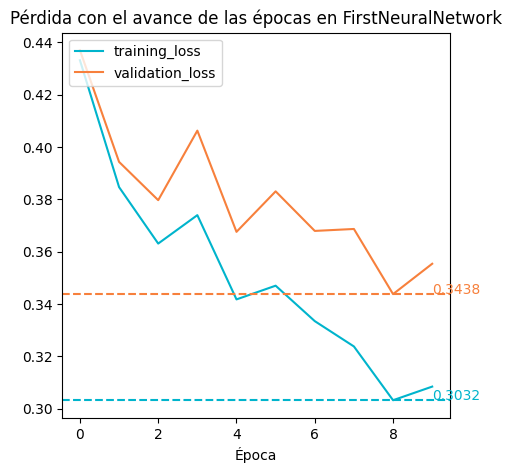

In [65]:
plot_loss(results_df, "Pérdida con el avance de las épocas en FirstNeuralNetwork")

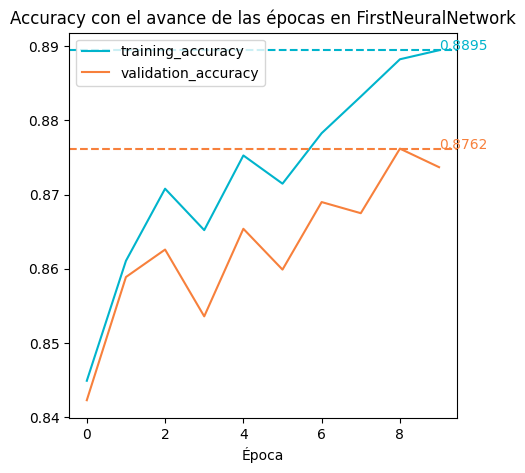

In [64]:
plot_accuracy(results_df, "Accuracy con el avance de las épocas en FirstNeuralNetwork")

Como es esperable, el modelo presenta un mejor desempeño (en cuanto a accuracy) sobre el conjunto de entrenamiento que sobre el de validación. Sin embargo, el modelo no presenta un sobreajuste significativo, ya que el desempeño sobre ambos conjuntos es muy comparable. Esto se puede ver en las curvas de pérdida y accuracy, donde ambas curvas se mantienen muy cercanas entre sí, coincidiendo en los momentos con picos y valles.

Por último, cabe destacar que aunque la accuracy alcance valores cercanos a 0.9 (bastante altos para este dataset), esto no significa que la red sea perfecta.
Si nos fijamos en la pérdida sobre el conjunto de validación, vemos que se minimiza en 0.34. Recordemos que el Cross Entropy Loss mide la distancia entre la distribución de probabilidad predicha por la red y la distribución de probabilidad real. Por lo tanto, una pérdida de 0.34 significa que la red no está muy segura de sus predicciones, ya que la distribución de probabilidad predicha es muy distinta a la real.

### Resultados en 100 epocas

Con el fin de introducirnos en la siguiente sección, extenderemos la anterior prueba. 

Utilizarlos el mismo número de etapas que hemos utilizado en la siguiente sección, con el fin de utilizar al anterior modelo y entrenamiento como punto de partida en búsqueda de una arquitectura que nos ofrezca mejores resultados (en aspectos que luego especificaremos).

In [ ]:
#warning Si ejecuta  con CUDA sin torch.use_deterministic_algorithms(True) se pierde reproducibilidad
modelo = FirstNeuralNetwork()
modelo = modelo.to(device)

cant_epocas = 100
learning_rate = 0.01

model_train_data_dict = entrenar_y_evaluar_por_epocas(train_dataloader, val_dataloader, cant_epocas, learning_rate, modelo)
save_data(model_train_data_dict, 'datos_parte_a_100_epocas')

Época 1
-------------------------------
Resultados de entrenamiento:
  Accuracy: 83.5%
  Cross Entropy Loss: 0.455996

Resultados de validación:
  Accuracy: 82.8%
  Cross Entropy Loss: 0.464927

Época 2
-------------------------------
Resultados de entrenamiento:
  Accuracy: 85.5%
  Cross Entropy Loss: 0.402393

Resultados de validación:
  Accuracy: 84.8%
  Cross Entropy Loss: 0.419426

Época 3
-------------------------------
Resultados de entrenamiento:
  Accuracy: 86.5%
  Cross Entropy Loss: 0.371455

Resultados de validación:
  Accuracy: 85.9%
  Cross Entropy Loss: 0.388674

Época 4
-------------------------------
Resultados de entrenamiento:
  Accuracy: 87.6%
  Cross Entropy Loss: 0.348769

Resultados de validación:
  Accuracy: 86.8%
  Cross Entropy Loss: 0.370623

Época 5
-------------------------------
Resultados de entrenamiento:
  Accuracy: 87.9%
  Cross Entropy Loss: 0.337171

Resultados de validación:
  Accuracy: 87.5%
  Cross Entropy Loss: 0.362979

Época 6
-----------------

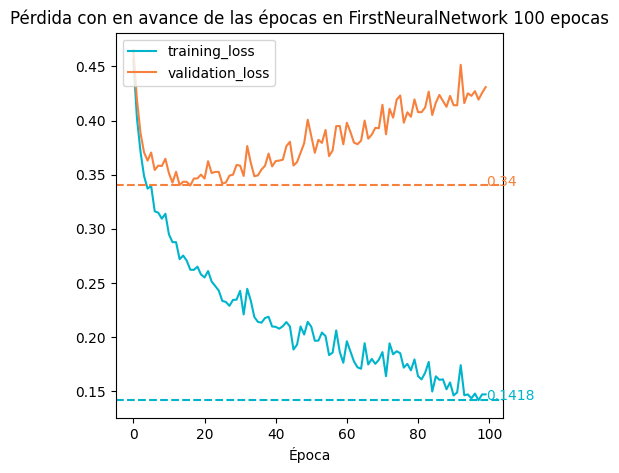

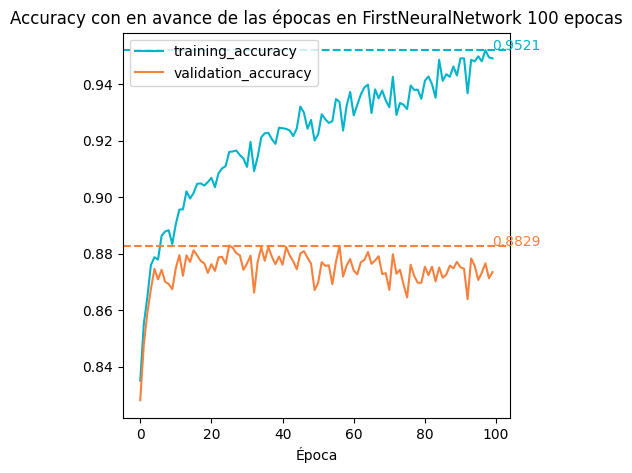

In [63]:
results_df_100 = read_data_to_df('datos_parte_a_100_epocas')
plot_loss(results_df_100, "Pérdida con en avance de las épocas en FirstNeuralNetwork 100 epocas")
plot_accuracy(results_df_100, "Accuracy con en avance de las épocas en FirstNeuralNetwork 100 epocas")

## Parte b - Tres arquitecturas propuestas

En la siguiente sección, nos enfocaremos en intentar proponer 3 nuevas arquitecturas con el fin de poder mejorar los resultados antes obtenidos. Estaremos variando los siguientes aspectos entre las arquitecturas: el número de neuronas por capa, el número de capas y la función de activación. 
Luego, para cada una de ellas, buscaremos cuál es el tamaño del batch (con eso nos referimos a que realizaremos entrenamiento por lotes, y un hiperparámetro que será el tamaño de los mismos) y la tasa de entrenamiento (learning rate) que mejores resultados nos ofrecen. 

Para ello nuevamente usaremos un conjunto de validación que hemos aislado para observar la exactitud (accuracy) y el valor de la función de costo, luego analizaremos los resultados de cada propuesta con el fin de mejorar en la siguiente. También analizaremos cuestiones referidas al sobre ajuste, el cual será el punto de entrada a la siguiente sección.

Nuestro punto de partida será la arquitectura de la parte anterior. Debido a que vamos a experimentar con modelos de mayor tamaño (y por ende requieren de más iteraciones para ser ajustados), aumentaremos el número de épocas a ejecutar a 100, hemos hecho pruebas que escapan a este cuaderno con epocas mayores que 100 que además de tornarse demasiado lento no tenían una mejora sutancial.

Como podemos observar en los resultados de haber entrenado el modelo anterior sobre 100 etapas, el cambio de la accuracy no está determinado por los valores obtenidos de la función de costo. Observar en la Figura 3 y 4 de la sección anterior, podemos ver que luego de las 30 épocas, el aumento en el valor “loss” fue significativo, pero aunque hubo una caída en la accuracy, la misma no fue en absoluto tan pronunciado. Lo antes dicho será incluso más notorio en otros modelos, en los cuales la accuracy no parece disminuir, pero el aumento en el “loss” por sobre ajuste (overfitting) es extremadamente notorio. 

Por esto último, nos vemos forzados a decidir cuál medida de performance a utilizar a la hora de escoger el modelo.

En términos de cuál modelo es “más útil”, podríamos suponer que la accuracy sería una buena unidad de performance, ya que nos informa de cuantas veces la red fue capaz de predecir correctamente. Pero la accuracy no tiene en cuenta con “cuanta seguridad” el modelo afirma su resultado, mientras que la “loss” aportada por la función de costo sí. No es lo mismo que el modelo devuelva un vector de probabilidades, donde la categoría correcta es la mayor, pero en un caso con un 90% y en otro con un 30%. Esto se debe a que esta última considera la “seguridad” con la que la red decide, ya que parte de su cálculo es la distancia entre el vector objetivo y el obtenido luego del "forward propagation".

Algo que es importante tener en cuenta, es que en el resto de este informe no hemos logrado superar el 91% de accuracy contra el conjunto de validación, y cuando se llegaba a esos números, el conjunto de entrenamiento era prácticamente “memorizado” por nuestra red, obteniendo valores de hasta un 98.0% de accuracy contra el conjunto antes mencionado.

Por lo tanto, como en la parte “A”, la accuracy da 88.2% sobre el conjunto de validación. Entendemos que será un reto superarlo, y que la diferencia no será sustancial. 

En términos de la función loss, el conjunto de entrenamiento llega a valores de 0.142 y en el conjunto de validación de 0.34.

### Forma de pruebas y  análisis de datos

Las pruebas serán realizadas sobre cada modelo, probaremos 3 tamaños batch diferentes: 4, 64 y 128 instancias. Hemos realizamos múltiples pruebas previas a este informe que escapan al alcance del mismo, y notamos que los valores de batch de mayor interés son los antes mencionados.

Además, utilizaremos 4 tipos de tasas de entrenamiento diferentes: 0.001, 0.005, 0.01 y 0.05. 



In [21]:
NUMERO_EPOCAS = 100

LEARING_RATE = [0.001, 0.005, 0.01, 0.05]
SIZES_BATCHES = [4, 64, 128]

In [22]:
# Guardamos temporalmente los datos del entrenamiento en la siguiente colección
datos_modelo_tasa_batch = [[[ [] ] * len(LEARING_RATE)] * len(SIZES_BATCHES)] * 3

La función `entrenar_red` nos permite entrenar el modelo basándonos en los parámetros antes dichos.

Como es evidente, si quien esté ejecutando ese cuaderno no cuenta con un equipamiento adecuado (como es nuestro caso... ), la duración de las celdas que llamen a esa función tiene un tiempo elevado. 
Es por eso que para facilitar el desarrollo de este documento, y la corrección del mismo, hemos guardado dentro de la carpeta"./backups" los resultados de cada prueba sobre cada modelo con los nombres `datos_z_x_y` donde x = 0, 1, 2 con batch 4, 64 y 128 respectivamente. Mientras que y = 0, 1, 2, 3 con learning rate 0.001, 0.005, 0.01 y 0.05 respectivamente, y donde z = 0, 1 y 2 si se trata del modelo propuesto 1, 2 o 3 respectivamente.



In [23]:
def entrenar_red(index_modelo, modeloClass):
    for index_size_batch, batch_size in enumerate(SIZES_BATCHES):
        # Particionamos los conjuntos de datos en tamaños de acuerdo al BATCH_SIZE
        train_loader_int = torchdata.DataLoader(
            mnist_train, batch_size=batch_size, shuffle=True
        )
        val_loader_int = torchdata.DataLoader(
            mnist_val, batch_size=batch_size, shuffle=True
        )

        for index_tasa_entrnamiento, learning_rate in enumerate(LEARING_RATE):
            # Instanciamos el modelo y lo guardamos en la GPU (si hay)
            modelo_int = modeloClass()
            modelo_int = modelo_int.to(device)

            print(f"\n------------------------------------")
            print(f"Batch {batch_size} | Learning_rate {learning_rate}")
            print(f"------------------------------------\n")

            # Entrenamos y evaluamos durante todas las epocas
            datos_modelo_tasa_batch[index_modelo][index_size_batch][index_tasa_entrnamiento] = entrenar_y_evaluar_por_epocas(
                train_loader_int,
                val_loader_int,
                NUMERO_EPOCAS,
                learning_rate,
                modelo_int,
            )

            # Guardamos los resultados
            save_data(
                datos_modelo_tasa_batch[index_modelo][index_size_batch][index_tasa_entrnamiento],
                f"backup/datos_{index_modelo}_{index_size_batch}_{index_tasa_entrnamiento}",
            )

    print("Done!")

La siguiente función nos permite graficar la accuracy o los valores de la función de costo para un modelo y un batch determinado. Para ello se leen los ficheros con los resultados de los entrenamientos antes realizados y se grafican.

In [24]:
def plot_modelo_batch_nombre(index_model, index_batch, nombre_label, nombre_tabla, batch_label, max_min):
    # Se leen los ficheros con los resultados de la función de costo y accuracy
    df_rate_1 = read_data_to_df('backup/datos_{}_{}_0'.format(index_model,index_batch))
    df_rate_2 = read_data_to_df('backup/datos_{}_{}_1'.format(index_model,index_batch))
    df_rate_3 = read_data_to_df('backup/datos_{}_{}_2'.format(index_model,index_batch))
    df_rate_4 = read_data_to_df('backup/datos_{}_{}_3'.format(index_model,index_batch))

    df = pd.DataFrame()
    df["{} | rate 0.001".format(nombre_label)] = df_rate_1[nombre_tabla]
    df["{} | rate 0.005".format(nombre_label)] = df_rate_2[nombre_tabla]
    df["{} | rate 0.01 ".format(nombre_label)] = df_rate_3[nombre_tabla]
    df["{} | rate 0.05 ".format(nombre_label)] = df_rate_4[nombre_tabla]
    
    # Se grafican los resultados
    plot_data(df, "Modelo {} | Batch {}".format(index_model + 1, batch_label), max_min, (8,11))


def plot_modelo_batch_accuracy(index_model, index_batch, batch_label):
    plot_modelo_batch_nombre(index_model,index_batch, "Accuracy", "validation_accuracy",batch_label, True)

def plot_modelo_batch_loss(index_model, index_batch, batch_label):
    plot_modelo_batch_nombre(index_model,index_batch, "Loss", "validation_loss",batch_label, False)

Como tenemos 12 ejecuciones diferentes para cada modelo, la visualización se puede tornar difícil. En consecuencia elegiremos el batch que tenga un modelo con el valor de su función "loss" lo más chico posible.

Ese minimo puede ser de cualquier época del entrenamiento de la red. Esto último es debido a que podemos guardar los parámetros de la red, y quedarnos con el estado de la red que se haya comportado de mejor manera contrastada contra el conjunto de validación. 

Luego estudiaremos el comportamiento de cada red dentro del batch variando por la learning rate.
Tendremos en consideración sobre todo los siguientes dos aspectos:
- El mejor valor de la función costo obtenido
- El overfiting según la variación de la función costo.

En algunos casos haremos excepciones, explorando batches con una "buena" performance en términos del resultado de la función "loss", en búsqueda de alguna alternativa que nos ofrezca un menor sobreajuste.

### Arquitectura propuesta 1  

Nuestra primera propuesta sería la misma red que en la parte A, pero utilizando como función de activación la conocida función ReLU.
El motivo es intentar utilizar una función de activación, la cual tenga mayores dificultades para saturarse, como es el caso de la función sigmoide. De todas formas, nuestras expectativas con esta prueba son bajas, ya el problema de un aprendizaje "lento" no se estaría presentado en la función de la sección anterior.

In [25]:
class RedUnaCapa32RELU(nn.Module):
    """
    Igual a la arqui. de la parte A pero con RELU como función de activación
    """
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.RELU_layer = nn.Sequential(
            nn.Linear(28*28, 32),
            nn.ReLU(),
            nn.Linear(32, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.RELU_layer(x)
        return logits

A continuación procedemos a entrenar el modelo con los tamaños de batch y learning rate antes dichos durante 100 épocas. Los resultados serán almacenados en el directorio `/backups` como se mencionó anteriormente.

In [ ]:
#Warning Si ejecuta  con CUDA sin torch.use_deterministic_algorithms(True) se pierde reproducibilidad
#Warning Ejecutar esta función demora en CPU aproximadamente 2h
entrenar_red(0, RedUnaCapa32RELU) 


------------------------------------
Batch 4 | Learning_rate 0.001
------------------------------------

Época 1
-------------------------------
Resultados de entrenamiento:
  Accuracy: 76.4%
  Cross Entropy Loss: 0.681661

Resultados de validación:
  Accuracy: 76.8%
  Cross Entropy Loss: 0.676145

Época 2
-------------------------------
Resultados de entrenamiento:
  Accuracy: 80.0%
  Cross Entropy Loss: 0.576780

Resultados de validación:
  Accuracy: 80.7%
  Cross Entropy Loss: 0.567812

Época 3
-------------------------------
Resultados de entrenamiento:
  Accuracy: 82.6%
  Cross Entropy Loss: 0.511685

Resultados de validación:
  Accuracy: 82.5%
  Cross Entropy Loss: 0.508482

Época 4
-------------------------------
Resultados de entrenamiento:
  Accuracy: 83.2%
  Cross Entropy Loss: 0.488571

Resultados de validación:
  Accuracy: 83.3%
  Cross Entropy Loss: 0.484496

Época 5
-------------------------------
Resultados de entrenamiento:
  Accuracy: 84.1%
  Cross Entropy Loss: 0.462

En este punto, los modelos han sido entrenados, y los datos de la función de costo y accuracy (según el conjunto de entrenamiento y validación) están almacenados en `./backup`. Procederemos a elegir el batch que haya obtenido el menor valor en su función de costo, de forma de analizar el comportamiento de la learning rate en dicho batch.

Para ello, hemos implementamos las dos siguientes funciones: La primera nos retorna el menor valor de la función de costo para cada learning rate dada una pareja modelo-batch. La segunda nos retorna el menor valor de la función de costo para cada batch dado un modelo.

In [26]:
def obtener_costos_minimos_por_modelo_batch(index_model, index_batch):
    df_rate_1 = read_data_to_df("backup/datos_{}_{}_0".format(index_model, index_batch))
    df_rate_2 = read_data_to_df("backup/datos_{}_{}_1".format(index_model, index_batch))
    df_rate_3 = read_data_to_df("backup/datos_{}_{}_2".format(index_model, index_batch))
    df_rate_4 = read_data_to_df("backup/datos_{}_{}_3".format(index_model, index_batch))

    return pd.DataFrame(
        data=[
            [LEARING_RATE[0], min(df_rate_1["validation_loss"])],
            [LEARING_RATE[1], min(df_rate_2["validation_loss"])],
            [LEARING_RATE[2], min(df_rate_3["validation_loss"])],
            [LEARING_RATE[3], min(df_rate_4["validation_loss"])],
        ],
        columns=["learing rate", "Loss minima"],
    )


def obtener_costos_minimos_por_modelo(index_model):

    minimos = [0, 0, 0]
    for index_batch in range(0, 3):
        obtener_costos_minimos_por_modelo_batch(index_model, index_batch)

        minimos[index_batch] = min(
            obtener_costos_minimos_por_modelo_batch(index_model, index_batch)[
                "Loss minima"
            ]
        )

    return pd.DataFrame(
        data=[
            ["Batch 4", minimos[0]],
            ["Batch 64", minimos[1]],
            ["Batch 128", minimos[2]],
        ],
        columns=["Batch", "Loss minima"],
    )

In [27]:
obtener_costos_minimos_por_modelo(0)

,Batch,Loss minima
0,Batch 4,0.326404
1,Batch 64,0.324613
2,Batch 128,0.335101


El modelo que tiene el menor valor en su función costo se encuentra en el batch 64, por lo tanto, siguiendo con el proceso antes mencionado, se analizara los resultados de cada learning rate dentro de este batch.

Se genera la siguiente gráfica con los datos antes mencionados, para mayor claridad se señaliza la mínima "loss" obtenida para cada learning rate, este valor también se muestra en la tabla debajo de la grilla.

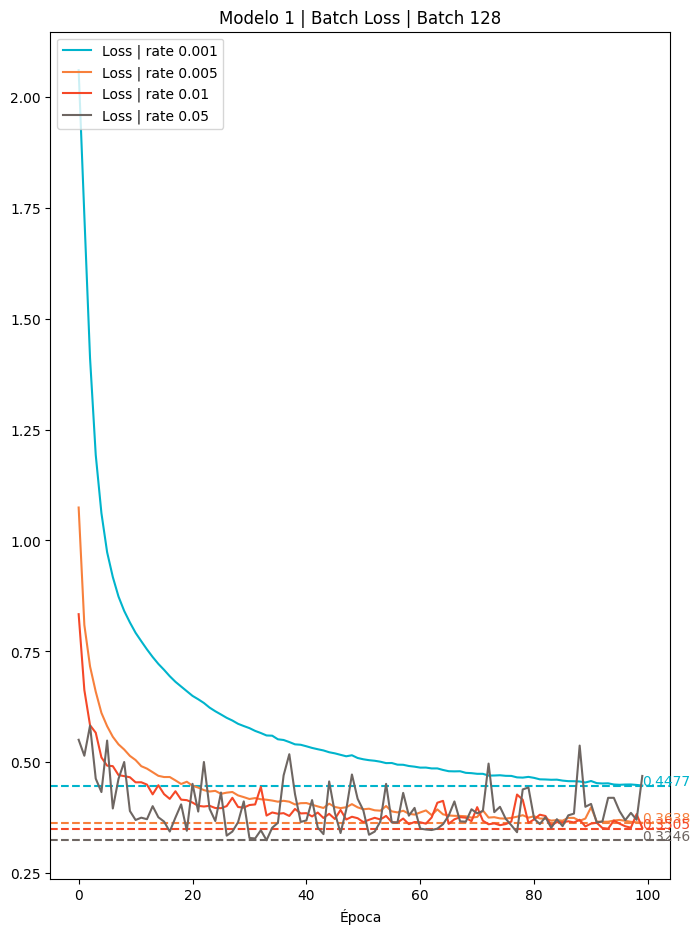

,learing rate,Loss minima
0,0.001,0.502728
1,0.005,0.395628
2,0.010,0.370119
3,0.050,0.335101


In [62]:
plot_modelo_batch_loss(0, 1 , "Loss | Batch 128")
obtener_costos_minimos_por_modelo_batch(0,2)

La primera observación a hacer de este modelo es que un learning rate de 0.05 logró superar al modelo presentado en la anterior sección. Además, este nuevo modelo presenta una oscilación pronunciada, en particular alcanzando picos mayores a 0.5 y un piso de 0.335. Por último, este modelo aparenta una tendencia al alta (overfiting) en su función de costo.

Nuestra suposición realizada al inicio de esta propuesta parece haber tenido sentido, concluyendo que modelo de la sección 'a' no presenta problemas de saturación. Eso nos lleva pensar en cambios arquitectónicos más haya de la función de activación. 

### Arquitectura propuesta 2 

El siguiente intento de mejora será aumentar la complejidad de la red, manteniendo la función de activación ReLU. En particular, proponemos una red con una única capa oculta de 128 neuronas, todas ellas la función de activación ReLU.

El objetivo de este modelo es ofrecer una red con un mayor número de parámetros, pero manteniendo la profundidad. La intención de esto sería permitir que cada neurona se pueda especializar de mejor manera en diferentes patrones, y que los mismos no deban solaparse debido a un número chico de neuronas en la capa. 

In [29]:
class RedUnaCapa128RELU(nn.Module):
    """
    Agregamos dos capas ocultas, de 32 nodos cada una.
    """

    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.RELU_layer = nn.Sequential(
             nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.RELU_layer(x)
        return logits

Procedemos a entrenar el modelo con los diferentes tamaños de batch y learning rate, de igual forma que la sección anterior.

In [ ]:
#Warning Si ejecuta  con CUDA sin torch.use_deterministic_algorithms(True) se pierde reproducibilidad
#Warning Ejecutar esta función demora en CPU aproximadamente 2h
entrenar_red(1,RedUnaCapa128RELU) 


------------------------------------
Batch 4 | Learning_rate 0.001
------------------------------------

Época 1
-------------------------------
Resultados de entrenamiento:
  Accuracy: 76.5%
  Cross Entropy Loss: 0.690103

Resultados de validación:
  Accuracy: 76.8%
  Cross Entropy Loss: 0.684743

Época 2
-------------------------------
Resultados de entrenamiento:
  Accuracy: 81.2%
  Cross Entropy Loss: 0.563176

Resultados de validación:
  Accuracy: 81.0%
  Cross Entropy Loss: 0.562730

Época 3
-------------------------------
Resultados de entrenamiento:
  Accuracy: 82.6%
  Cross Entropy Loss: 0.511669

Resultados de validación:
  Accuracy: 82.0%
  Cross Entropy Loss: 0.513649

Época 4
-------------------------------
Resultados de entrenamiento:
  Accuracy: 83.6%
  Cross Entropy Loss: 0.480004

Resultados de validación:
  Accuracy: 83.6%
  Cross Entropy Loss: 0.479395

Época 5
-------------------------------
Resultados de entrenamiento:
  Accuracy: 83.7%
  Cross Entropy Loss: 0.470

Procedemos a calcular el valor mínimo de función de costo para cada batch calculado en el modelo 2.

In [30]:
obtener_costos_minimos_por_modelo(1)

,Batch,Loss minima
0,Batch 4,0.294014
1,Batch 64,0.296638
2,Batch 128,0.295206


Lo primero que observamos es el valor de la función de costo para todos los batches es sustantivamente inferior a los obtenidos en el anterior modelo, además la diferencia entre ellos es prácticamente despreciable, menor a tres centésimas.  

Pero siguiendo la metodología propuesta, analizaremos los resultados para cada learning rate del batch de tamaño 4, ya que es el menor.

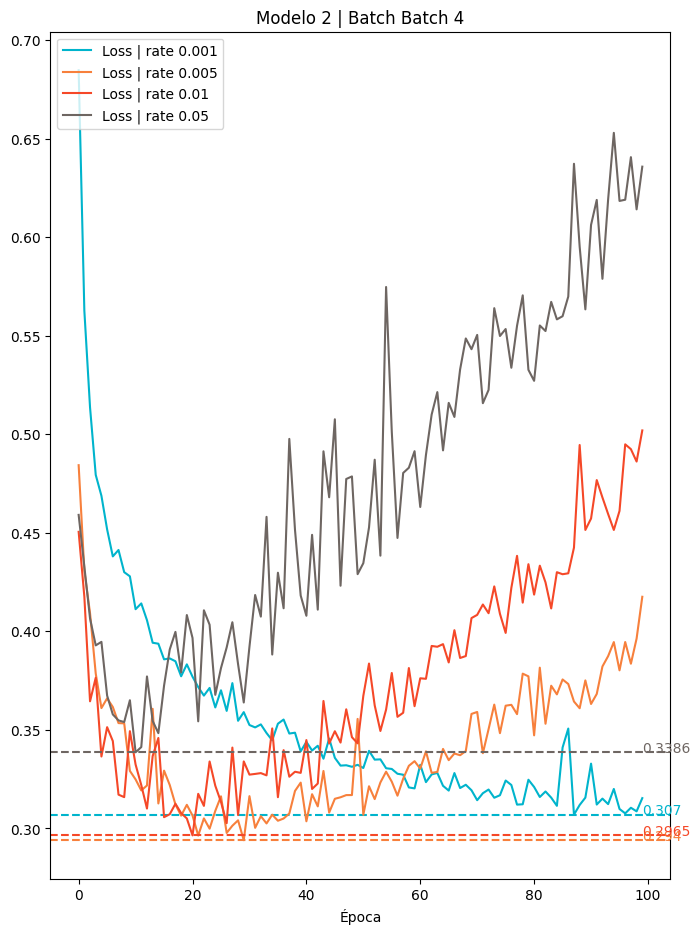

,learing rate,Loss minima
0,0.001,0.306980
1,0.005,0.294014
2,0.010,0.296460
3,0.050,0.338626


In [61]:
# Se grafica los valores de la funcion de costo para el batch 4 para el modelo 1
plot_modelo_batch_loss(1, 0 , "Batch 4") 
obtener_costos_minimos_por_modelo_batch(1,0)

Podemos observar que el modelo entrenado con learning rate de 0.005 hasta el momento ha sido el que ha obtenido el mínimo de la función de costo, pero todas ellas (excepto del learning rate 0.001) obtiene ese valor de loss una unica vez, y luego a partir de este punto comienzan un proceso de crecimiento sostenido del costo.  Se concluye que las 3 instancias tienen un sobre ajuste bastante marcado. 

Debido a que sus buenos resultados se dan en puntos concretos y no como tendencias, consideramos que este modelo entrenado de esta forma debería ser evaluado con técnicas de regularización previo a que sea viable su uso. 

Solamente los resultados obtenidos en el caso del learning rate 0.001 muestran desempeño mejor que el obtenido en la sección A, sin que ello implique un sobre ajuste significativo. 

Debido a lo antes comentado, estudiaremos los resultados del segundo mejor batch, ya que en cuanto al valor de la función de  costo es muy similar.

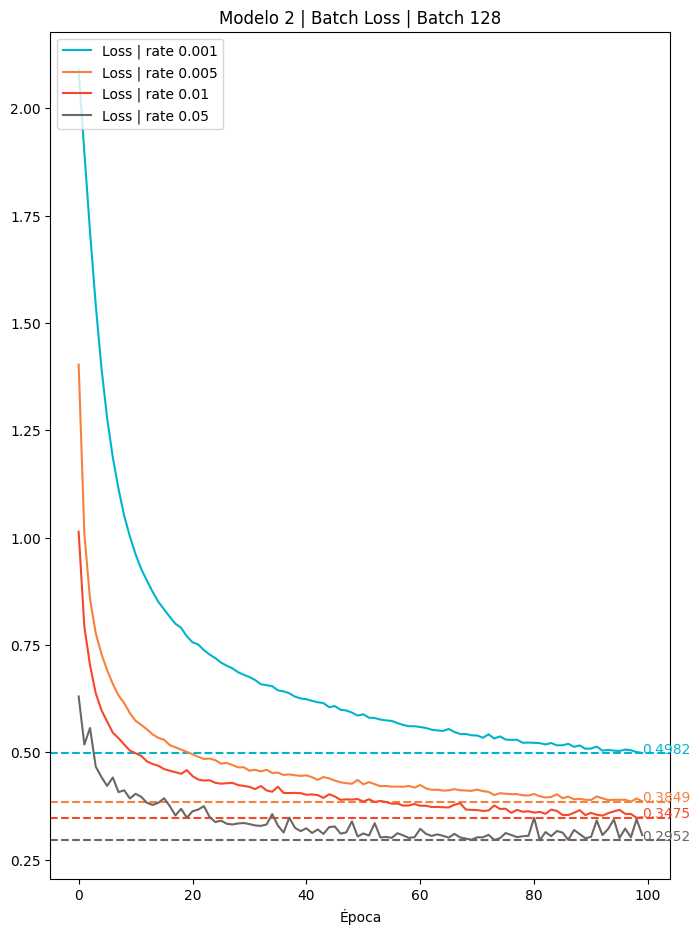

,learing rate,Loss minima
0,0.001,0.498230
1,0.005,0.384948
2,0.010,0.347493
3,0.050,0.295206


In [60]:
# Se grafica los valores de la funcion de costo para el batch 128 para el modelo 1
plot_modelo_batch_loss(1, 2 , "Loss | Batch 128") 
obtener_costos_minimos_por_modelo_batch(1,2)

Analizando los últimos resultados, creemos que los 4 casos no tienen sobre ajuste. En cambio, se tiene una cierta oscilación a medida que la learning rate crece, como es de esperarse al usar descenso por gradiente. Creemos que eso se puede mejorar aplicando técnicas de regularización.

Además, el caso de learning rate de 0.5 tiene valores de la función de costo bajos, y múltiples de estos son cercanos al mínimo alcanzar, mejorando los resultados del batch anteriormente estudiado.

A continuación se despliega accuracy sobre el conjunto de entrenamiento y validación para el modelo antes descrito con batch de 128 instancias y learning rate 0.5  

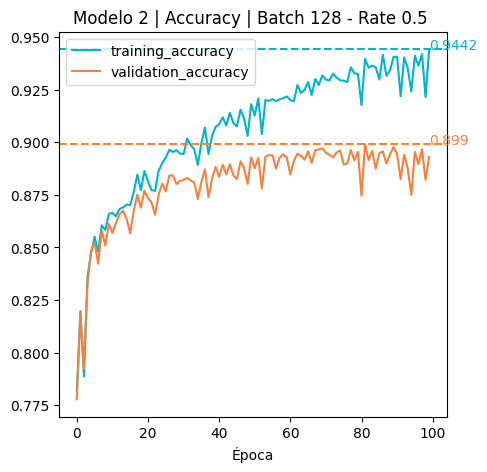

In [59]:
plot_accuracy(read_data_to_df('backup/datos_1_2_3'), "Modelo 2 | Accuracy | Batch 128 - Rate 0.5 ")

Se observa una accuracy máxima en el conjunto de entrenamiento de un 94,4%, y de un 89,9% en la validación. Es claro que este modelo no es solamente superior al de la sección "A" en cuestiones de la  función de costo, sino también en accuracy. 

### Arquitectura propuesta 3

La última arquitectura propuesta sigue la misma idea de razonamiento que la anterior: aumentar la complejidad de la red con el fin de  capturar mayor detalle y patrones de la misma.

En esa direccion, se aumenta el numero de capaz ocultas, insertando una segunda capa oculta de 64 neuronas. Se mantiene la primera capa como en el anterior modelo y el uso de la función ReLU como función de activacion de ambas capas.

In [35]:
class Red128_64_RELU(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.RELU_layer = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.RELU_layer(x)
        return logits

Entrenamos el modelo con todos los batches y learning rates.

In [ ]:
#Warning Si ejecuta  con CUDA sin torch.use_deterministic_algorithms(True) se pierde reproducibilidad
#Warning Ejecutar esta función demora en CPU aproximadamente 2h
entrenar_red(2,Red128_64_RELU) 


------------------------------------
Batch 4 | Learning_rate 0.001
------------------------------------

Época 1
-------------------------------
Resultados de entrenamiento:
  Accuracy: 72.4%
  Cross Entropy Loss: 0.754060

Resultados de validación:
  Accuracy: 72.2%
  Cross Entropy Loss: 0.750913

Época 2
-------------------------------
Resultados de entrenamiento:
  Accuracy: 78.8%
  Cross Entropy Loss: 0.603331

Resultados de validación:
  Accuracy: 78.4%
  Cross Entropy Loss: 0.605082

Época 3
-------------------------------
Resultados de entrenamiento:
  Accuracy: 80.8%
  Cross Entropy Loss: 0.537071

Resultados de validación:
  Accuracy: 80.1%
  Cross Entropy Loss: 0.542029

Época 4
-------------------------------
Resultados de entrenamiento:
  Accuracy: 82.9%
  Cross Entropy Loss: 0.489937

Resultados de validación:
  Accuracy: 82.3%
  Cross Entropy Loss: 0.490996

Época 5
-------------------------------
Resultados de entrenamiento:
  Accuracy: 83.5%
  Cross Entropy Loss: 0.468

In [36]:
obtener_costos_minimos_por_modelo(2)

,Batch,Loss minima
0,Batch 4,0.294471
1,Batch 64,0.299086
2,Batch 128,0.295995


Nuevamente para todos los casos el valor de la función de costo fue menor que el primer modelo propuesto, pero los resultados son muy  parejos si lo comparamos entre el anterior modelo y el actual. Lo que definira que nos decantemos por un modelo o por otro sera el sobre ajuste. 

Comenzamos por analizar los resultados del mejor batch para el modelo 2 segun la función de costo; el batch con 4 instancias. 

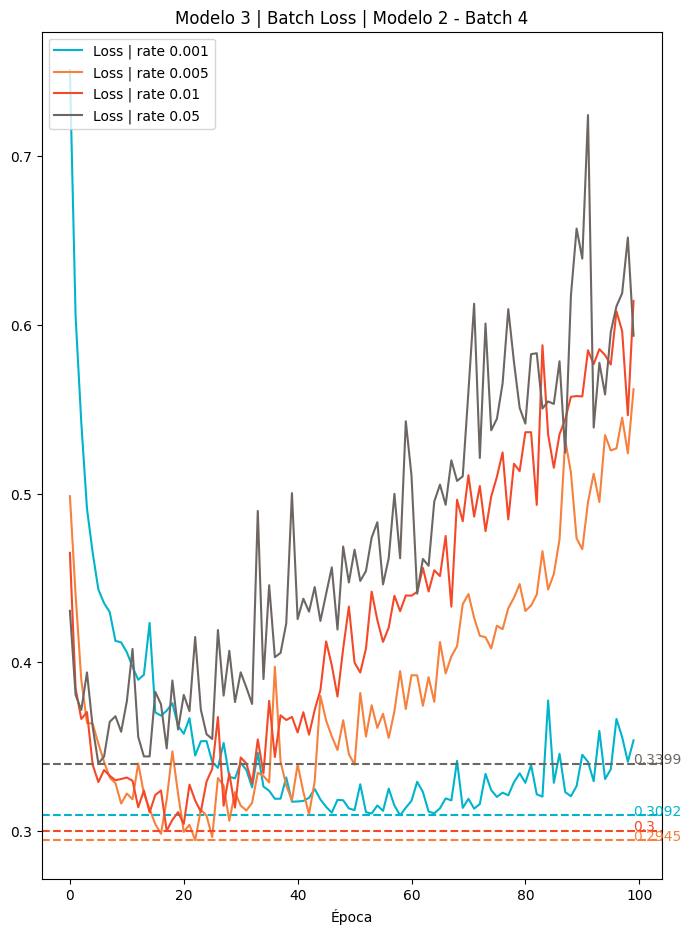

,learing rate,Loss minima
0,0.001,0.309239
1,0.005,0.294471
2,0.010,0.300037
3,0.050,0.339945


In [58]:
plot_modelo_batch_loss(2, 0 , "Loss | Modelo 2 - Batch 4")
obtener_costos_minimos_por_modelo_batch(2,0)

Los anteriores resultados son similares a los obtenidos en el anterior modelo con el batch 4, a excepcion de que en este, todos los casos tienen sobre ajuste. Los resultado de su función de costo tambien son muy similares. 

Por el mismo argumento que en el modelo pasado, analizamos los resultados del segundo mejor batch. 

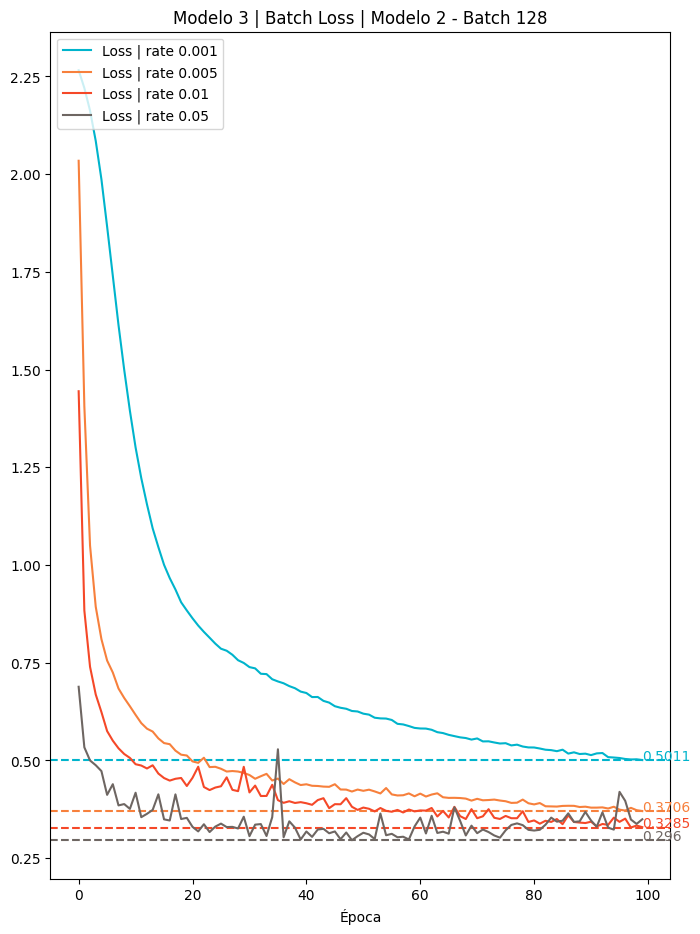

,learing rate,Loss minima
0,0.001,0.501088
1,0.005,0.370554
2,0.010,0.328512
3,0.050,0.295995


In [57]:
plot_modelo_batch_loss(2, 2 , "Loss | Modelo 2 - Batch 128")
obtener_costos_minimos_por_modelo_batch(2,2)

Nuevamente notemos que esos resultados tiene un gran parecido al batch de 128 instancias para el modelo 2 en cuanto al loss para cada learning rate. Aunque en el modelo actual observamos una mayor osilacion (o inestabilidad), junto un leve aumento sostenido en el valor del loss a partir de las ultimas 20 epocas. 

### ¿Cuál de los modelos propuestos es el mejor?

Finalmente, elegimos el modelo, el cual su función de costo sea lo menor posible, intentando evitar los modelos con sobre ajuste. En esa línea el modelo que mejor se adaptó fue el modelo 1, entrenado con un batch de 128 instancias con un learning rate de 0.05. Aquellos modelos, que eran superiores en cuanto a la función de costo, sufrían de un sobre ajuste severo. 

Someteremos este modelo a un proceso de regularización con el fin de intentar mejorarlo aún más. 

## Parte c - Regularización

En esta sección vamos a tomar el modelo que mejor se comportó en la parte anterior y vamos a tratar de aumentar aún mas su performance aplicando la técnica de regularización "_dropout_".
Uno de los principales objetivos al usar dropout es minimizar el sobre ajuste; si bien es cierto que nuestro modelo no muestra una "panza" pronunciada en la gráfica de pérdida, estamos teniendo un acurrancy en el conjunto de entrenamiento bastante elevado. 

Además la técnica cuenta con varios beneficios más que son:
- Evitar la coadaptación de unidades, esto significa que las neuronas no se vuelvan dependientes unas de otras.
- Ayuda a mejorar la generalización del modelo, lo que resulta en un mejor rendimiento en datos de prueba no vistos.
- Evitará que la red aprenda el ruido de los datos de entrenamiento, los cuales pueden tener el mismo comportamiento o no en otros ejemplos no vistos (perjudicando así el desempeño).

### Funcionamiento de dropout 

Dropout fuerza a la red a aprender características más robustas y evitar la memorización de datos de entrenamiento a través del apagado aleatorio de neuronas.
Cuenta con un parametro `dropout_prob` el cual indica la probabilidad de que una neurona sea desactivada durante el entrenamiento.

Es necesario notar que las neuronas se apagan únicamente en el entrenamiento volviendo a estár activas en la validación, de esto se encarga pytorch cambiando model.train a model.eval (contemplado en nuestro proceso de aprendizaje), por lo tanto no es necesario realizar ninguna modificación al proceso de entrenamiento ni a la evaluación.

En la literatura se puede encontrar que un valor típico de uso de dropout_prob es 0.5 lo cual nos indica que aproximadamente la mitad de las neuronas se van a apagar, esto puede ser bueno para datos muy complejos y en gran volumen (millones de datos), pero para nuestro problema creemos que puede ser conveniente el uso de un valor de 0.2, aún así vamos a computar con ambos dropout para poder verificar lo argumentado.

Para nuestro caso vamos a utilizar dropout en la única capa oculta, si bien es cierto que es posible aplicar dropout también a la capa de entrada (esto sería equivalente a apagar pixeles aleatorios en la imagen), creemos que al tener una única capa oculta se le puede dificultar a la red para aprender patrones.

In [39]:
import torch.nn as nn

class RedUnaCapa128RELUDropout_02(nn.Module):
    def __init__(self, dropout_prob=0.2):
        super().__init__()
        self.flatten = nn.Flatten()
        self.RELU_layer = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),  
            nn.Linear(128, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.RELU_layer(x)
        return logits
    
class RedUnaCapa128RELUDropout_05(nn.Module):
    def __init__(self, dropout_prob=0.5):
        super().__init__()
        self.flatten = nn.Flatten()
        self.RELU_layer = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),  
            nn.Linear(128, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.RELU_layer(x)
        return logits


In [40]:
modelo = RedUnaCapa128RELUDropout_02()
modelo = modelo.to(device)
modelo2 = RedUnaCapa128RELUDropout_05()
modelo2 = modelo2.to(device)

Ahora entrenaremos. Con la intención de evaluar el mejor modelo en la siguiente sección, usamos una implementación sencilla de early stopping para que el modelo corra el total de épocas, pero que también se guarde la versión que mejor se desempeña sobre el conjunto de validación. Ese modelo se almacenará en el fichero best_model.pth, será utilizando en la siguiente sección.

Procedemos a entrenar

Los datos de entrenamiento serán guardados en los archivos datos_dropout_0.2.csv y datos_dropout_0.5.csv con la misma semántica que los anteriores ficheros.

In [ ]:
#Warning Si ejecuta  con CUDA sin torch.use_deterministic_algorithms(True) se pierde reproducibilidad

batch_size = 128
learning_rate = 0.05

train_dataloader = torchdata.DataLoader(
    mnist_train, batch_size=batch_size, shuffle=True
)
val_dataloader = torchdata.DataLoader(mnist_val, batch_size=batch_size, shuffle=True)
i = 0
drops = ["0.2", "0.5"]
for modelo in [modelo, modelo2]:
    i = i + 1
    data_model = entrenar_y_evaluar_por_epocas(
        train_dataloader,
        val_dataloader,
        NUMERO_EPOCAS,
        learning_rate,
        modelo,
        True if i == 1 else False, # usamos early stopping para dropout==0.2
    )
    save_data(
        data_model,
        "datos_dropout_" + drops[i - 1],
    )


Época 1
-------------------------------
Resultados de entrenamiento:
  Accuracy: 78.5%
  Cross Entropy Loss: 0.632204

Resultados de validación:
  Accuracy: 78.3%
  Cross Entropy Loss: 0.628831

Guardando modelo...
Época 2
-------------------------------
Resultados de entrenamiento:
  Accuracy: 82.1%
  Cross Entropy Loss: 0.526220

Resultados de validación:
  Accuracy: 81.8%
  Cross Entropy Loss: 0.523380

Guardando modelo...
Época 3
-------------------------------
Resultados de entrenamiento:
  Accuracy: 82.7%
  Cross Entropy Loss: 0.493757

Resultados de validación:
  Accuracy: 83.1%
  Cross Entropy Loss: 0.491687

Guardando modelo...
Época 4
-------------------------------
Resultados de entrenamiento:
  Accuracy: 84.4%
  Cross Entropy Loss: 0.452487

Resultados de validación:
  Accuracy: 84.0%
  Cross Entropy Loss: 0.453237

Guardando modelo...
Época 5
-------------------------------
Resultados de entrenamiento:
  Accuracy: 84.1%
  Cross Entropy Loss: 0.442156

Resultados de validac

### Análisis del uso de dropout 

##### Acurrancy en datos de entrenamiento

Comenzamos graficando los datos.

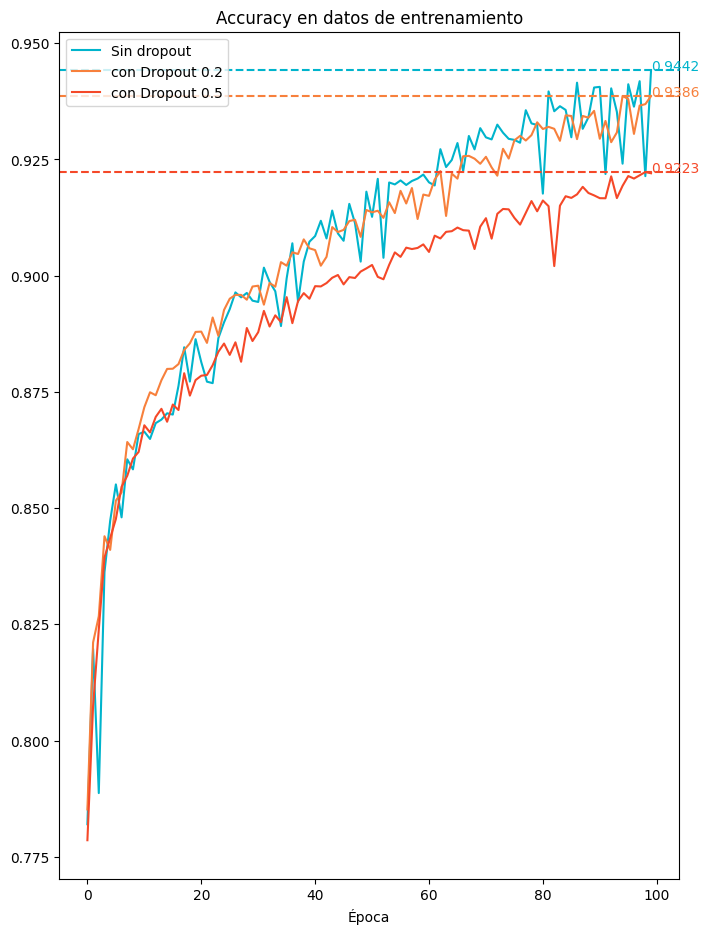

In [56]:
df_rate_1 = read_data_to_df('backup/datos_1_2_3')
df_rate_2 = read_data_to_df('datos_dropout_0.2')
df_rate_3 = read_data_to_df('datos_dropout_0.5')

df = pd.DataFrame()
df["Sin dropout"] = df_rate_1["training_accuracy"]
df["con Dropout 0.2"] = df_rate_2["training_accuracy"]
df["con Dropout 0.5"] = df_rate_3["training_accuracy"]

plot_data(df, "Accuracy en datos de entrenamiento", True, (8,11))

En esta gráfica se puede observar como es reducido el acurrancy en el conjunto de entrenamiento con los dropout, además como es de esperar dropout 0.5 obtiene un menor acurrancy que dropout 0.2 dado que se apaga un mayor porcentaje de neuronas, consiguiendo una mejora con dropout 0.5 en cuanto a sobreajuste, veamos que sucede con el resto de las metricas. 

##### Acurrancy en validación

Graficamos:

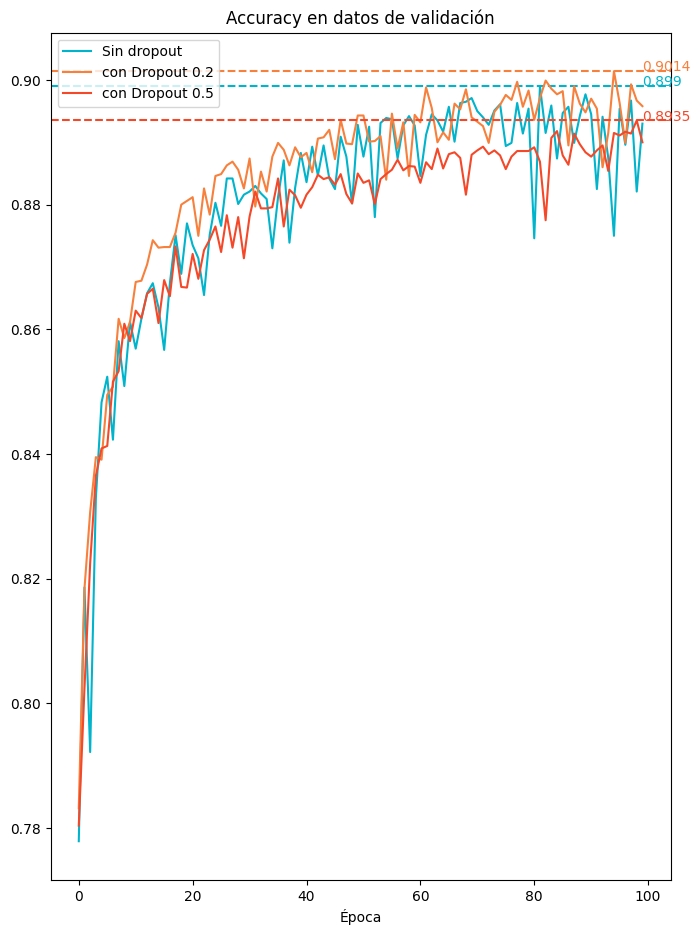

In [55]:
df_rate_1 = read_data_to_df('backup/datos_1_2_3')
df_rate_2 = read_data_to_df('datos_dropout_0.2')
df_rate_3 = read_data_to_df('datos_dropout_0.5')

df = pd.DataFrame()
df["Sin dropout"] = df_rate_1["validation_accuracy"]
df["con Dropout 0.2"] = df_rate_2["validation_accuracy"]
df["con Dropout 0.5"] = df_rate_3["validation_accuracy"]

plot_data(df, "Accuracy en datos de validación", True, (8,11))


Se observa que la mejora obtenida por dropout=0.2 (con respecto a 0.5) es de 0.0024, un tanto pequeña. Pero lo cierto es que es muy díficil obtener una mejora sustancial en cuanto al acurrancy cuando ya tenemos un modelo que llega a valores cercanos a 90%.

Para el caso de dropout=0.5 sucede que la validacion empeora en 0.005, un resultado que concuerda con lo argumentado al comienzo de la sección: estamos apagando la mitad de neuronas y como el problema no tiene gran cantidad de datos, nos estamos pasando para el otro lado. En concreto, tenemos un caso de underfitting, esto es que el modelo no se ajusta lo suficiente a los datos de entrenamiento y no es capaz de aprender lo suficientemente bien los patrones, en este caso un mayor número de épocas hubiera sido útil.

##### Pérdida

Vemos los datos:

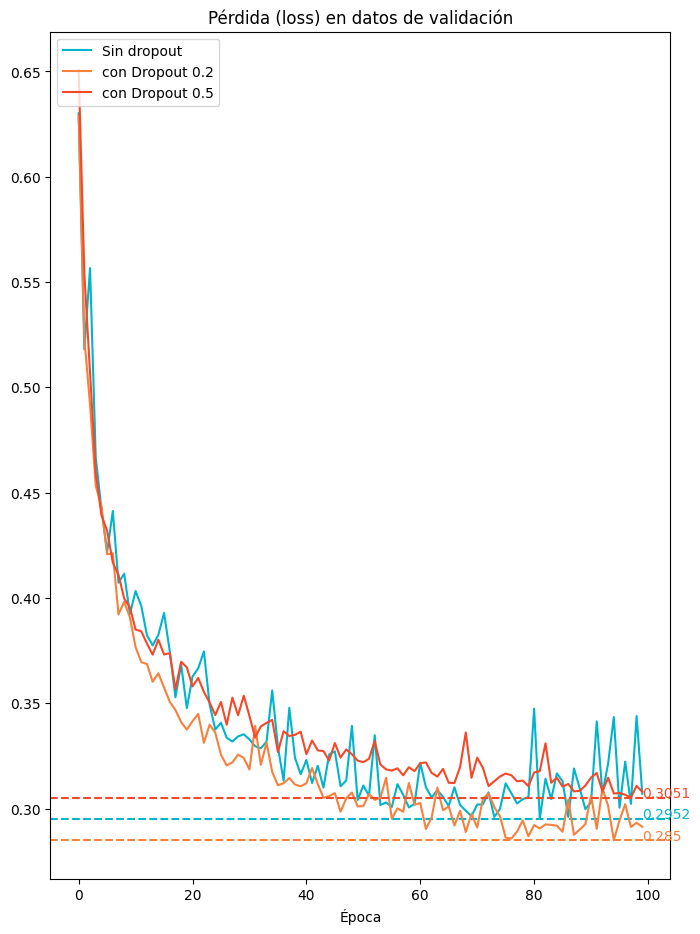

In [54]:
df_rate_1 = read_data_to_df('backup/datos_1_2_3')
df_rate_2 = read_data_to_df('datos_dropout_0.2')
df_rate3 = read_data_to_df('datos_dropout_0.5')

df = pd.DataFrame()
df["Sin dropout"] = df_rate_1["validation_loss"]
df["con Dropout 0.2"] = df_rate_2["validation_loss"]
df["con Dropout 0.5"] = df_rate3["validation_loss"]

plot_data(df, "Pérdida (loss) en datos de validación", False, (8,11))

Se observa que hay una mejora con dropout=0.2 llegando hasta un mínimo de 0.285, superando el mínimo sin dropout antes obtenido de 0.295, esto nos indica qu efectivamente usar una tasa moderada de dropout fue mejor y además que logramos mejorar el modelo en 0.01.

El caso de dropout=0.5 empeora teniendo origen en la explicación detallada anteriormente.

### Conclusión

En conclusión, mantenemos el argumento de que para problemas que no tienen un gran volumen de datos para entrenar y redes que no son grandes, la utilización de un dropout grande puede ser contraprudecente, aunque logren una mejora en cuanto al overfiting, no logran un buen desempeño; y que la utilización de un valor mas moderado para nuestro problema es mas ventajoso considerando el número de épocas elegido. 
Otra conclusión que se deriva de una mejora tan pequeña es que la utilización de valores de dropout por debajo de 0.2 o por encima de 0.5 derivarian en un cambio minúsculo o en underfiting respectivamente.

## Parte d - Evaluación de los resultados

### Evaluación del mejor modelo obtenido

El mejor modelo obtenido luego de las secciones anteriores fué la red RELU de 128 capas, haciendo uso de un dropout de 0.2, además es necesario recalcar que en el cuaderno hemos hecho muchas pruebas con varios modelos y muchos de ellos tenian sobreajuste o oscilaciones (como es el caso del modelo escogido), por esta razón utilizamos una técnica llamada Early-Stopping.

Early-Stopping consiste en quedarse con el modelo que haya dado el mínimo error (o loss) en validación, para una cualquiera de las épocas.

Dado que para el modelo que tomamos, el loss baja de forma suave; el early stopping no genera un cambio sustancial, pero nos parece un buen aporte recalcar este punto.
En está sección tomaremos este modelo y lo evaluaremos en el conjunto de test con varias métricas y compararemos contra los resultados reportados en el sitio oficial del dataset.

#### Obtención de las medidas recall, precision, f1 y accurancy sobre el conjunto de evaluación

Cargamos el modelo desde el archivo "best_model.pth".

In [44]:
modelo = RedUnaCapa128RELUDropout_02()
load_model(modelo, "best_model")

In [45]:
from sklearn.metrics import (
    recall_score,
    precision_score,
    f1_score,
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
)

Iteramos sobre el conjunto de evaluación, evaluamos el modelo y nos guardamos: imagen, predicción en forma de label, salida del modelo completa y valor real o verdad.

In [46]:
def evaluacion(dataloader):
    imagenes = []
    pred = []
    pred_probabilidades = []
    real = []

    # Seteamos el modelo en modo evaluación
    modelo.eval()

    # Deshabilitamos el cálculo de gradientes, ya que no los necesitamos para evaluar el modelo
    with torch.no_grad():
        for image, label in dataloader:
            image, label = image.to(device), label.to(device)
            pred_prob = modelo(image)
            pred_label = pred_prob.argmax(dim=1)

            pred_probabilidades.append(pred_prob.detach().numpy())
            imagenes.append(image.numpy())
            pred.append(pred_label.numpy())
            real.append(label.numpy())
    return imagenes, pred, pred_probabilidades, real

Computamos la evaluación.

In [47]:
imagenes, pred, pred_probabilidades, real = evaluacion(test_loader)

Tabla con recall, precision y f1 por clase.

In [48]:
import pandas as pd
data = {
    "recall_score": recall_score(real,pred,average=None),
    "precision_score": precision_score(real,pred,average=None),
    "f1_score": f1_score(real,pred,average=None)
}
pd.DataFrame(data)

,recall_score,precision_score,f1_score
0,0.856,0.836755,0.846268
1,0.971,0.984787,0.977845
2,0.832,0.786389,0.808552
3,0.905,0.868522,0.886386
4,0.841,0.805556,0.822896
5,0.954,0.979466,0.966565
6,0.649,0.777246,0.707357
7,0.961,0.935735,0.948199
8,0.975,0.965347,0.970149
9,0.960,0.959041,0.959520


La semántica de _recall_ es que cuanto mas alto sea, el modelo es mejor en identificar positivos verdaderos y minimizar los falsos negativos, cosa que es importante cuando dar un falso negativo es crítico.

Para el caso de _precision_, es mas alto cuando el modelo es mejor en evitar predicciones falsas positivas.

Por último _f1_ es una métrica que combina recall y precisión, es útil cuando se necesita un equilibro entre verdaderos positivos y la reduccion de falsos positivos y falsos negativos.

Se destaca que los números en general son bastante buenos, una cosa que nos sorprende es
las poca diferencia entre recall y precision, que por lo general no son tan similares.

Nos llama la atención la 7ma fila, correspondiente a Shirt. Para este caso el recall es de 0.649 lo cual indica que de las 100 veces que era positivo 36 veces dijo que no lo era. 
Este comportamiento puede darse por varios motivos, una posibilidad puede ser que no haya la suficiente cantidad de ejemplos de entrenamiento de Shirt y por ello le cueste entrenarse para dar respuestas correctas; otra posibilidad puede ser que Shirt, al ser muy parecida con otros tipos de ropa, no es tan identificable y los patrones que pueden aprenderse con esta arquitectura no son lo suficientemente complejos.

### Matriz de confusión

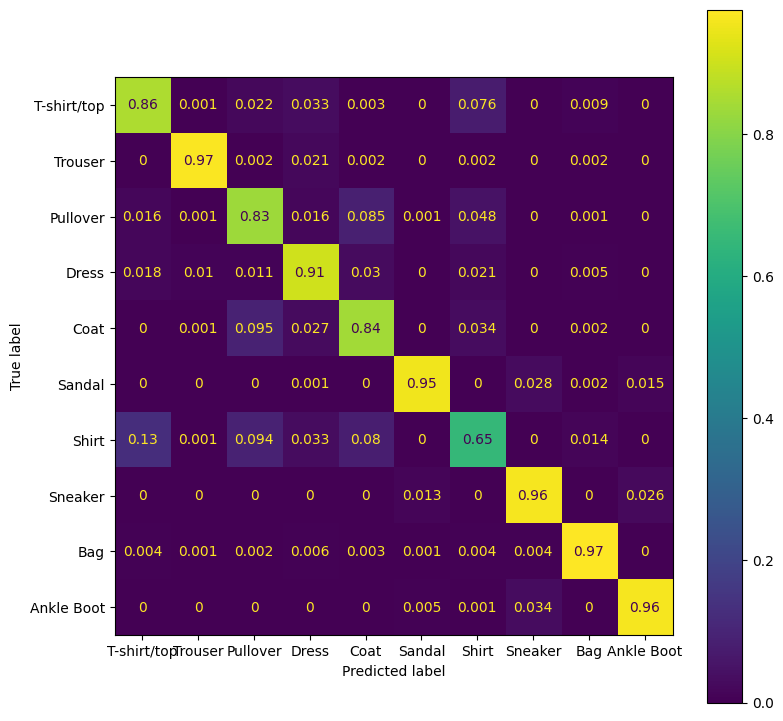

In [50]:
cm = confusion_matrix(real, pred)

cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
cm = ConfusionMatrixDisplay(
    confusion_matrix=cm_norm,
    display_labels=[
        "T-shirt/top",
        "Trouser",
        "Pullover",
        "Dress",
        "Coat",
        "Sandal",
        "Shirt",
        "Sneaker",
        "Bag",
        "Ankle Boot",
    ]
)
fig, ax = plt.subplots(figsize=(9,9))
cm.plot(ax=ax)

La diagonal muestra un buen desempeño en general a excepción de lo ya antes mencionado respecto al Shirt.

Al observar la  matriz de confusión se destaca la simetría. Desde nuestra perspectiva humana, se entiende que si al clasificar un tipo de prenda A confunde con un tipo de prenda B, también debería confundir al clasificar el tipo de prenda B con el tipo de prenda A.

Es importante notar que esta simetria no es directa. Por ejemplo, se vé que confunde Tshirt con Shirt un 0.13% de las veces pero al revés solo 0.076% (aproximadamente la mitad). 
Esto tendría una explicación lógica para un humano que sería que existen distintos tamaños de mangas para una Tshirt, aquellas Tshirt que sean de manga mas larga van a generar mayor confusión con las Shirt. 

Es importante recalcar que hay una influencia por la cantidad de datos de prueba de cada tipo.

### Comparación con medidas de la web del dataset

In [51]:
accuracy_score(real,pred)

0.8904

Para esta sección, tomaremos del sitio del dataset dos datos:

- Accuracy máximo reportado, obtenido por la arquitectura "WRN40-4 8.9M params", de 0.967. Acreditado a https://github.com/ajbrock.

- Accuracy obtenido por evaluadores humanos "Human Performance", de 0.835. 

Nos gustaría disponer de otras medidas a parte de accuracy, pero no existen en la web del dataset y la directiva era bastante clara en ese sentido.

Tomando lo obtenido en la celda de código anterior (el accuracy dió 0.8904), nuestro modelo se encuentra en el medio de las dos medidas mencionadas.

A partir de esos datos, concluimos que nuestras redes están lejos de lo que se podría considerar "estado del arte" para este dataset. El valor obtenido está casi 10 puntos por encima de lo obtenido por nosotros, lo que muestra un amplio camino por recorrer. Sobretodo teniendo en cuenta que comenzamos con una arquitectura (parte 'a') que conseguía un accuracy de 0.8829 (contra validacion) y con mucha experimentación sólo conseguimos mejorar hasta el 0.8904.

Es importante resaltar que la mejor accuracy conseguida contra e l  conjunto de validación fue de 90.14%, por lo tanto, hemos perdido un 1% cuando se realizó  la prueba en el conjunto de evaluación.

Por último, es importante destacar que se logró una mejor performance que la de los humanos evaluados; concretamente un aumento de 5 a 6 puntos. Es una lástima no tener más métricas que el accuracy, ya que hubiese resultado de provecho poder analizar si los errores en esas evaluaciones siguen los mismos patrones de confusión que los obtenidos por nosotros.

## Parte e - Las Instancias más "difíciles"

Comenzamos calculando la entropía de cada una de las instancias de evaluación. Tomaremos los índices de los valores máximos asociados y graficaremos 10 instancias.

In [52]:
def softmax_np(x):
    "Para convertir la salida de la red en una distribución de probabilidad"
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

def entropy(arr):
    "Para calcular la entropia de cada distribución"
    return - np.sum(arr * np.log10(arr))

# Calculamos cada probablilidad
probabilidades = np.array([softmax_np(salida_red) for salida_red in pred_probabilidades])

# Calculamos las entropias
entropias = np.array([entropy(prob) for prob in probabilidades])

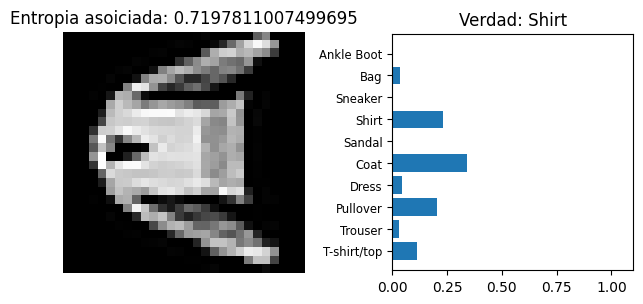

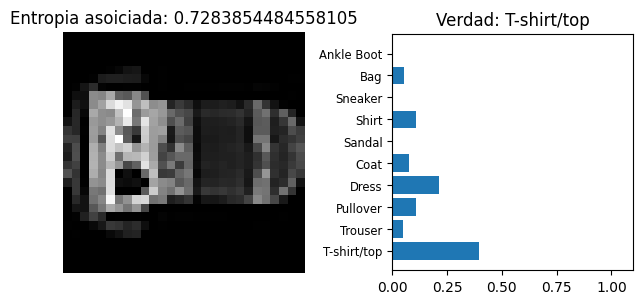

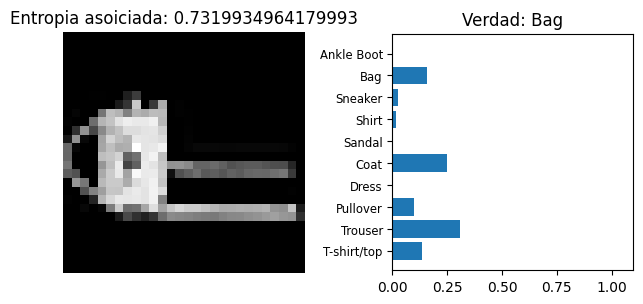

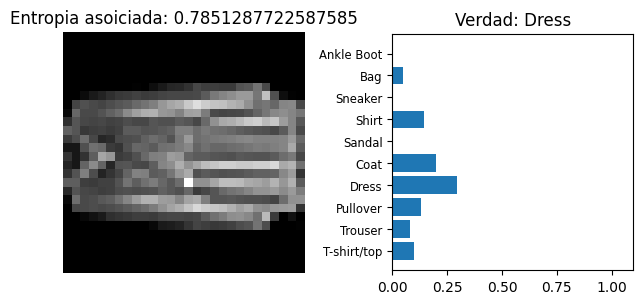

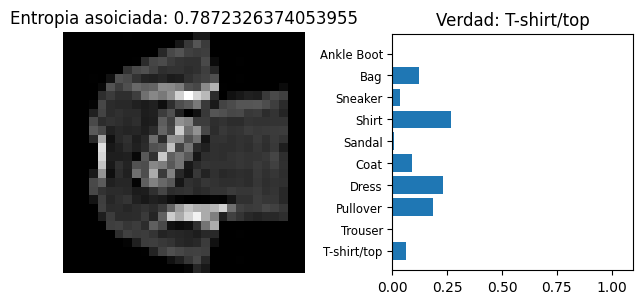

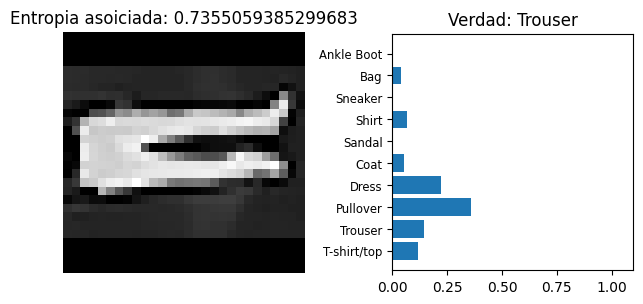

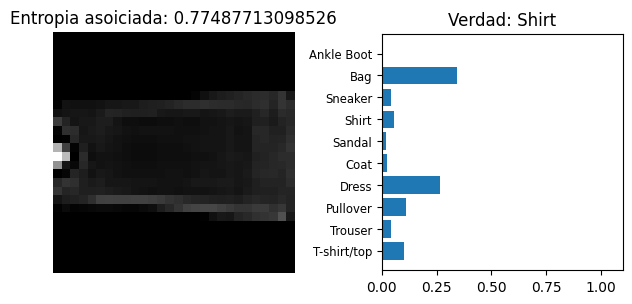

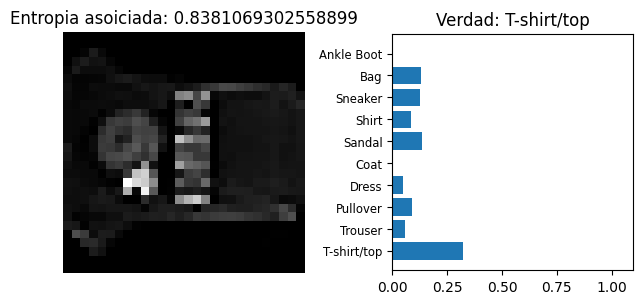

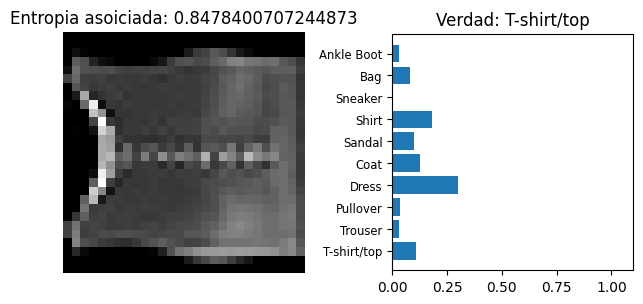

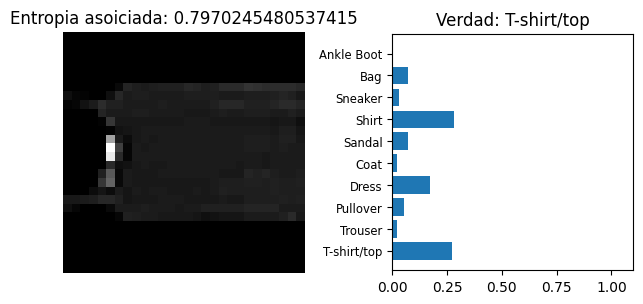

In [53]:
# Cantidad de ejemplos que vamos a mostrar
CANT_EJEMPLOS = 10

# Elegimos las K mayores entropias
indices_peores_entropias = np.argpartition(entropias, -CANT_EJEMPLOS)[-CANT_EJEMPLOS:]


def mostrar_ejemplo(i, ind):
    "Para cada entropia mala, muestra la figura y grafica las probabilidades"
    global imagenes, entropias, probabilidades

    prob = probabilidades[ind][0]
    entropia = entropias[ind]
    imagen = transforms.ToTensor()(imagenes[ind][0]).view(1, -1).view(1, 28, 28)
    true_label = real[ind][0]
    reportar_predicción(imagen, prob, entropia, true_label)

for i, ind in enumerate(indices_peores_entropias):
    mostrar_ejemplo(i, ind)

Primero debemos recordar que la entropía es la medida de incertidumbre que hay en una variable aleatoria. A partir de ahora referenciaremos una alta entropía como una alta incertidumbre.

Lo primero que salta a la vista al ver estos resultados es que todas las instancias están rotadas 90° en sentido anti-horario con respecto a lo que uno consideraría «derecho». Por lo tanto, parecería que el modelo experimenta incertidumbre máxima cuando las imágenes no están derechas.

Desde el punto de vista de entrenamiento, creemos que entrenar cada imagen 4 veces (una orientación cada vez) sería suficiente para mejorar este aspecto del modelo.

Otro aspecto que notamos, es que algunas de las imágenes mostradas tienen poco «contraste», no hay mucha variación en la intensidad de los píxeles y quizá esa sea una razón extra para que no tenga tanta certeza.

Por último, notamos que haciendo una evaluación personal de las imágenes mostradas, somos incapaces de elegir una categoría con una total seguridad. Por lo que, a grandes rasgos, la performance del modelo no estaría muy por debajo del nuestro como personas.